# Data Science Use Case: ASX Index Predictor Model - Part 2
# Written by: Ricky Chang

## 3) Feature engineering
### Given the raw dataset, what scaling and transformations can be applied to individual features to improve model fit accuracy?

Which scaler should be used to scale features? It depends on the feature distribution. Chi-square goodness of fit test can indicate whether the chosen transformation is suitable.

In [1]:
import pandas as pd
import tensorflow as ts
import seaborn as sns
sns.set()
import sklearn as sk
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
# apply fix to statsmodels library
from scipy import stats
stats.chisquareprob = lambda chisq, df: stats.chi2.sf(chisq,df)

### Read in the joined raw dataset

In [2]:
folder = 'datasets\\'
df_asset = pd.read_csv(filepath_or_buffer = folder + 'df_asset.csv', index_col=0)
df_asset.columns

Index(['Gold', 'Silver', 'Copper', 'Iron', 'WTI', 'Brent',
       'RBA_Cash_Rate_Target_Date', 'RBA_Cash_Rate', 'Close_AUDUSD',
       'Close_USDCNH', 'Temperature_-_(Celsius)', '_Year', '_Statistics',
       '_Country', '_ISO3', 'Month', 'Temperature_-_(Celsius)_CHN',
       '_Year_CHN', '_Statistics_CHN', '_Country_CHN', '_ISO3_CHN',
       'Month_CHN', 'BXM', 'SPTR', 'SPX', 'PUT', 'CLL', 'BXY', 'VIX', 'VXO',
       'BXMD', 'BFLY', 'CLLZ', 'CMBO', 'CNDR', 'PPUT', 'Close_IEF', 'Open_IEF',
       'High_IEF', 'Low_IEF', 'Close_LQD', 'Open_LQD', 'High_LQD', 'Low_LQD',
       'Open_XAO', 'High_XAO', 'Low_XAO', 'Close_XAO', 'Return_(%)_XAO',
       'Open', 'High', 'Low', 'Close', 'Return_(%)', 'Open_XFL', 'High_XFL',
       'Low_XFL', 'Close_XFL', 'Return_(%)_XFL'],
      dtype='object')

This code snippet performs these steps:
1. Creates a new feature 'CopperGoldRatio', which is a bullish economic indicator. Given the hypothesis that equity stock indices reflect the overall economy, then the CopperGoldRatio and index prices should be positively correlated as well.
1. Creates new features from asset prices suffixed with '(Return %)'. This is the first step in normalisation of raw prices.
1. Natural log is applied to the (Return %) features. This is a non-linear transformation which in effect scales the features to a normal distribution, if the raw prices were lognormally distributed.
1. Drop all NA records.

In [3]:
from sklearn.preprocessing import StandardScaler
assets = ['Gold','Silver','Iron','Copper','WTI','Brent','RBA_Cash_Rate', 'Close_AUDUSD',
       'Close_USDCNH', 'Close_LQD', 'Close_IEF', 'Temperature_-_(Celsius)','Temperature_-_(Celsius)_CHN', 'BXM', 'SPTR', 'SPX', 'PUT', 'CLL', 'BXY', 'VIX', 'VXO',
       'BXMD', 'BFLY', 'CLLZ', 'CMBO', 'CNDR', 'PPUT']
unscaled_inputs = df_asset[assets]
unscaled_inputs['CopperGoldRatio'] = unscaled_inputs['Copper'] / unscaled_inputs['Gold']
unscaled_inputs['LQDIEFRatio'] = unscaled_inputs['Close_LQD'] / unscaled_inputs['Close_IEF']
unscaled_inputs['AUDCNH_FXRate'] = unscaled_inputs['Close_AUDUSD'] / unscaled_inputs['Close_USDCNH']
assets.append('CopperGoldRatio')
assets.append('LQDIEFRatio')
assets.append('AUDCNH_FXRate')

def func_return(x,y):
    return (x - y) / y
def func_log_return(x,y,z):
    return math.log1p(z + func_return(x,y))

# Apply Log Returns formula scaling
scaled_inputs = unscaled_inputs
for a in assets:
    scaled_inputs[a + '_(Return_%)'] = func_return(scaled_inputs[a], scaled_inputs[a].shift(1))
    #scaled_inputs[a + ' (Log Return %)'] = 15 + scaled_inputs[a + ' (Return %)']
    #scaled_inputs[a + ' (Log Return %)'] = scaled_inputs[a + ' (Log Return %)'].map(math.log1p)
#scaled_inputs = scaled_inputs.dropna()
#asset_scaler = StandardScaler()
#asset_scaler.fit(unscaled_inputs)
#scaled_inputs = asset_scaler.transform(unscaled_inputs)

C:\Users\mahle\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mahle\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\mahle\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

## 4) Model selection 

1st principle of model selection - a simpler model is better than a complex one, as long as model accuracy is not significantly compromised. Hence,

Model #1: Logistic Regression | Model #2 shall be XGBoost | Model #3 Naive Bayes

After all models are fitted, the intention is to stack the results of these models together, to see if that results in greater predictive accuracy.

Look-ahead bias should be avoided at all costs; as this will discredit any predictions generated by the model.

### 4.1) Logistic Regression Model
The log (Return %) features have been selected for this model. The target is a binary classifer which returns:
* True if SPTR (Return %) is greater than 0.01 (buy), False otherwise

In [17]:
scaled_inputs.columns

Index(['Gold', 'Silver', 'Iron', 'Copper', 'WTI', 'Brent', 'RBA_Cash_Rate',
       'Close_AUDUSD', 'Close_USDCNH', 'Close_LQD', 'Close_IEF',
       'Temperature_-_(Celsius)', 'Temperature_-_(Celsius)_CHN', 'BXM', 'SPTR',
       'SPX', 'PUT', 'CLL', 'BXY', 'VIX', 'VXO', 'BXMD', 'BFLY', 'CLLZ',
       'CMBO', 'CNDR', 'PPUT', 'CopperGoldRatio', 'LQDIEFRatio',
       'AUDCNH_FXRate', 'Gold_(Return_%)', 'Silver_(Return_%)',
       'Iron_(Return_%)', 'Copper_(Return_%)', 'WTI_(Return_%)',
       'Brent_(Return_%)', 'RBA_Cash_Rate_(Return_%)',
       'Close_AUDUSD_(Return_%)', 'Close_USDCNH_(Return_%)',
       'Close_LQD_(Return_%)', 'Close_IEF_(Return_%)',
       'Temperature_-_(Celsius)_(Return_%)',
       'Temperature_-_(Celsius)_CHN_(Return_%)', 'BXM_(Return_%)',
       'SPTR_(Return_%)', 'SPX_(Return_%)', 'PUT_(Return_%)', 'CLL_(Return_%)',
       'BXY_(Return_%)', 'VIX_(Return_%)', 'VXO_(Return_%)', 'BXMD_(Return_%)',
       'BFLY_(Return_%)', 'CLLZ_(Return_%)', 'CMBO_(Return_%)',
     

In [18]:
target_asset = 'SPTR'
feature_columns = scaled_inputs.filter(regex='(Return_%)').columns.to_list()
feature_columns.remove(target_asset + '_(Return_%)')
for f in ['Temperature_-_(Celsius)', 'Temperature_-_(Celsius)_CHN', 'BFLY', 'Close_LQD', 'CLLZ', 'Gold', 'Silver', 'Copper', 'Iron', 'Brent', 'VIX', 'PUT', 'BXM', 'BXMD', 'SPX', 'RBA_Cash_Rate']:
    feature_columns.remove(f + '_(Return_%)')
    
classifier = scaled_inputs[target_asset +'_(Return_%)'].shift(1) > 0.01
dataset = scaled_inputs[feature_columns].join(classifier.to_frame(), how='inner').dropna()
target = dataset.iloc[:,-1]
features = dataset.iloc[:,:-1]

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
reg = LogisticRegression()
reg.fit(features,target.values)

C:\Users\mahle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# Feature Significance
These are the features of the model, ranked from most to least important. The top 3 features are:
* WTI_(Return_%)
* CopperGoldRatio_(Return_%)
* VXO_(Return_%)

Odds Ratio close to 1 indicates that the feature does not contribute significantly to the model, and could be removed from the model.

In [19]:
print('The model accuracy is: '+ str(100* reg.score(features,target.values)) + '%')
feature_name = features.columns.values
summary_table = pd.DataFrame(columns=['Feature Name'], data = feature_name)
summary_table['Coefficient'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table['Odds_Ratio'] = np.exp(summary_table.Coefficient)
summary_table = summary_table.sort_values('Odds_Ratio', ascending = False)
summary_table

The model accuracy is: 64.70588235294117%


,Feature Name,Coefficient,Odds_Ratio
1,WTI_(Return_%),1.290314,3.633928
11,CopperGoldRatio_(Return_%),0.893321,2.443231
7,VXO_(Return_%),0.751852,2.120924
13,AUDCNH_FXRate_(Return_%),0.407379,1.502874
2,Close_AUDUSD_(Return_%),0.383662,1.467649
10,PPUT_(Return_%),0.363519,1.438383
5,CLL_(Return_%),0.363056,1.437717
12,LQDIEFRatio_(Return_%),0.300846,1.351001
0,Intercept,0.294713,1.342740
6,BXY_(Return_%),0.246015,1.278919


## Conclusion of Part 2
Initial fitting of Model #1 Logistic Regression is complete. 

The accuracy requires improvements to >80% to be a useful model for prediction. 

In Part 3, a different model will be chosen to improve upon the accuracy of the current model.

# Data Science Use Case: ASX Index Predictor Model - Part 3

## Introduction
In Part 2, Model #1 Logistic Regression was implemented on our feature engineered dataset. The objective of creating a functional binary classifier was achieved, however, the accuracy of the model was insufficient. 

## Objective
In Part 3, a new model shall be implemented on the same dataset from Part 2, with the goal of achieving better predictive accuracy. That model is XGBoost, which has been implemented to great success in multiple Kaggle data science competitions. See https://xgboost.readthedocs.io/en/latest/

## Parameter Explanation
### Test Size
The standard practice of splitting the dataset into training and test sets is used below. 

The variable test_size = 0.3 specifies that 30% of the dataset shall be used for testing, with the remaining 70% used for model training.

## Evaluation metric
The evaluation metric specifies an objective function to measure how well the model fits (and subsequently makes predictions) against the training data. The process of training the model determines the parameters that minimise the error between the predicted and actual values. 

The variable eval_metric='error' specifies the default evaluation metric for binary classifiers.

## Training rounds
The xgboost default of 100 training rounds is used. The aim of each training round is to find a parameter which lowers the value of objective function. The lower the objective function, the greater the model accuracy.

This process is known as 'gradient boosting'.

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
model = xgb.XGBClassifier()
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(features, target.values, test_size=test_size, random_state=seed)
eval_set = [(X_train, y_train), (X_test, y_test)]
#eval_metric = ["auc","error"]
model.fit(X_train, y_train, eval_metric='error', eval_set=eval_set)
#%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.144578	validation_1-error:0.277778
[1]	validation_0-error:0.108434	validation_1-error:0.138889
[2]	validation_0-error:0.084337	validation_1-error:0.222222
[3]	validation_0-error:0.084337	validation_1-error:0.194444
[4]	validation_0-error:0.084337	validation_1-error:0.166667
[5]	validation_0-error:0.096386	validation_1-error:0.138889
[6]	validation_0-error:0.084337	validation_1-error:0.194444
[7]	validation_0-error:0.072289	validation_1-error:0.194444
[8]	validation_0-error:0.060241	validation_1-error:0.194444
[9]	validation_0-error:0.072289	validation_1-error:0.222222
[10]	validation_0-error:0.060241	validation_1-error:0.166667
[11]	validation_0-error:0.072289	validation_1-error:0.166667
[12]	validation_0-error:0.060241	validation_1-error:0.166667
[13]	validation_0-error:0.060241	validation_1-error:0.166667
[14]	validation_0-error:0.036145	validation_1-error:0.166667
[15]	validation_0-error:0.060241	validation_1-error:0.166667
[16]	validation_0-error:0.048193	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

The code below plots the value of objective function over successive model training rounds.

The model no longer improves in accuracy after 20 rounds, and thus could be early stopped before the default of 100. For large datasets, where model training is computationally expensive, the time savings are significant.

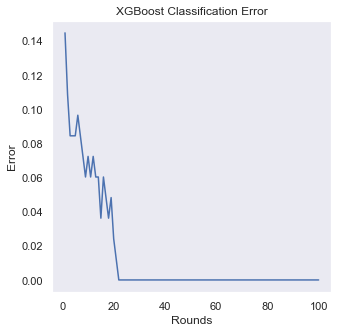

In [36]:
x = np.arange(1,101,1)
y = model.evals_result()['validation_0']['error']

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='Rounds', ylabel='Error',
       title='XGBoost Classification Error')
ax.grid()
plt.rcParams['figure.figsize'] = [5, 5]
fig.savefig("test.png")
plt.show()

As expected, XGBoost generates a model with much greater predictive accuracy than the Logistic Regression model provided in scikit-learn.

In [34]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("The model accuracy is: %.2f%%" % (accuracy * 100.0))

The model accuracy is: 86.11%


The code below generates a plot of the predictive tree generated in the training process.

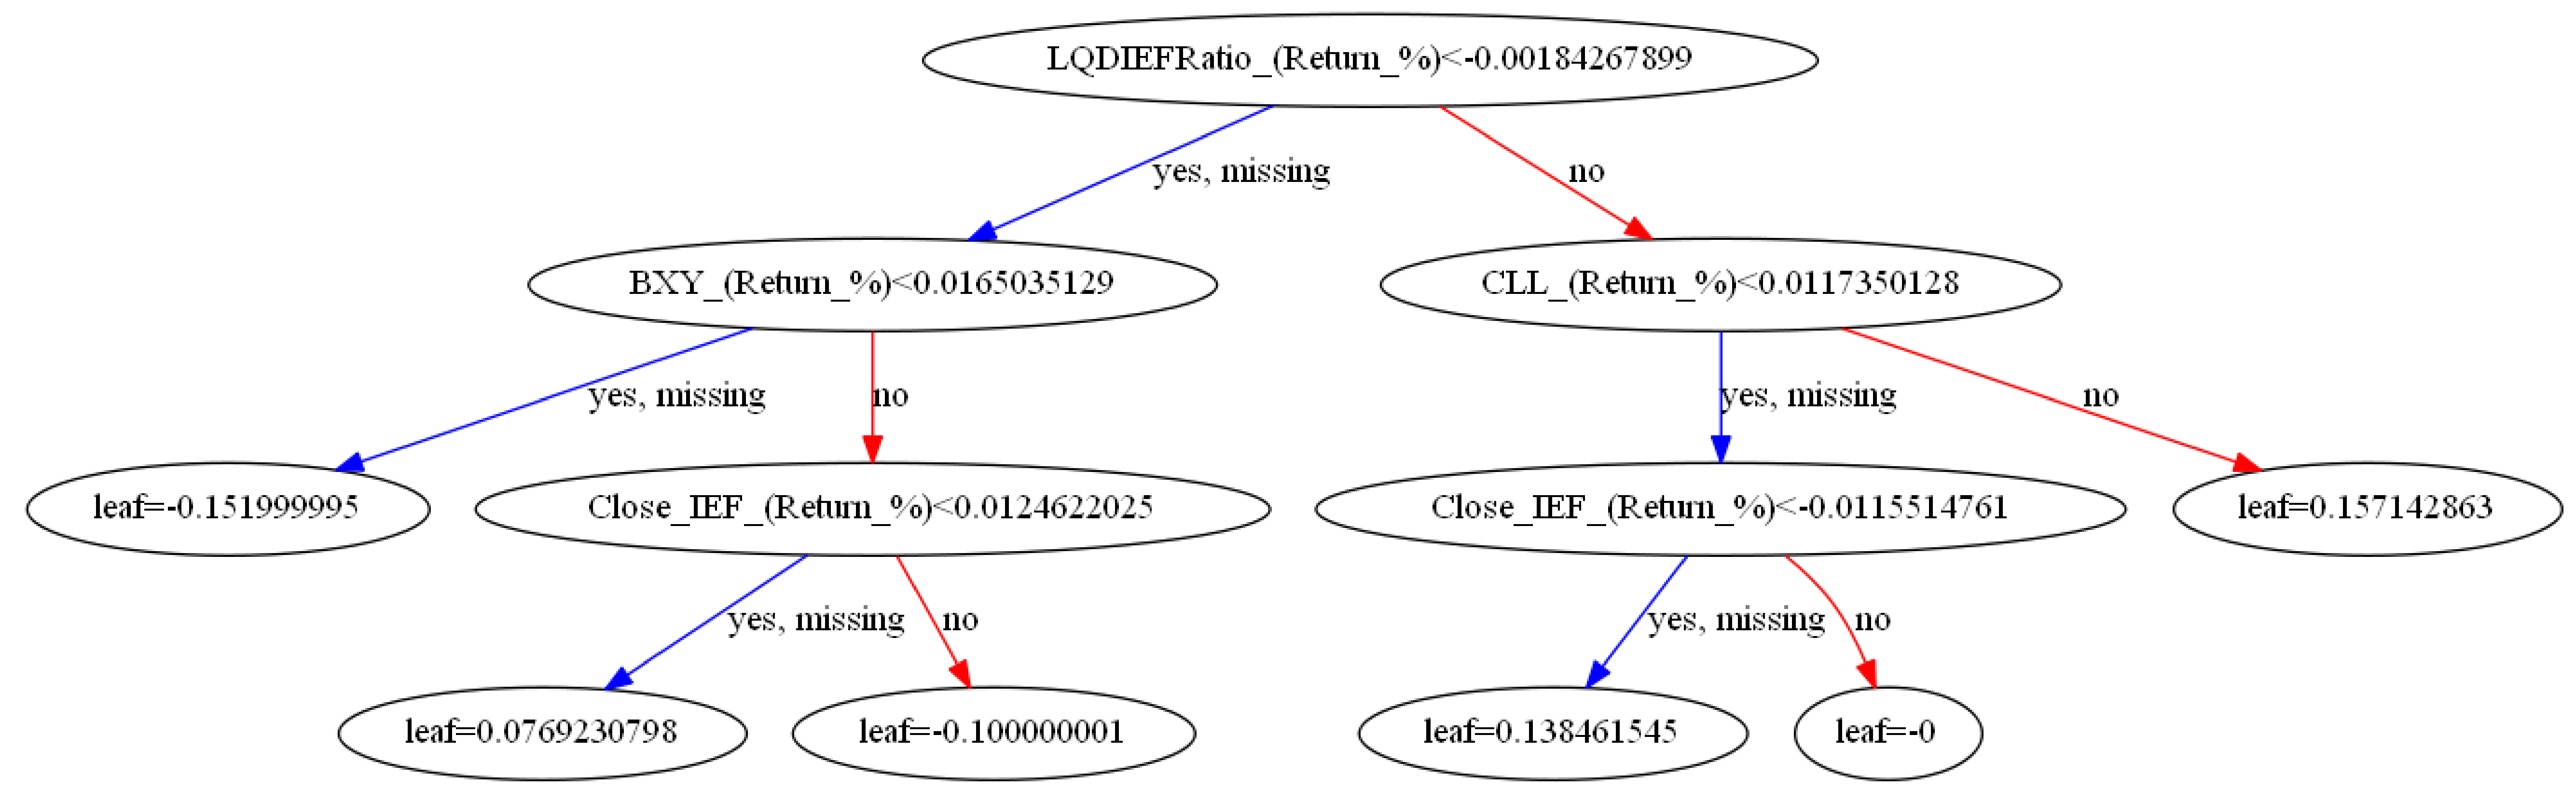

In [16]:
xgb.plot_tree(model)
plt.rcParams['figure.figsize'] = [100, 30]
plt.show()

From the F score plot below, the top 3 most important features are:

* LQDIEFRatio_(Return_%)
* BXY_(Return_%)
* CopperGoldRatio_(Return_%)

The only feature in the top 3 for both models is CopperGoldRatio_(Return_%).

Note that the model learns which features are important without human input. This can uncover insights from datasets that are free from various human biases.

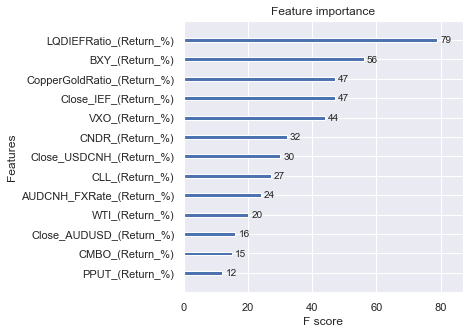

In [14]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()